In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!echo '{"username":"kushgabani","key":"b834f07f0c1414fcfc6367556b6538a5"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.68G/3.69G [01:09<00:00, 26.5MB/s]
100% 3.69G/3.69G [01:09<00:00, 57.2MB/s]


In [ ]:
!unzip /content/respiratory-sound-database.zip -d dataset

Archive:  /content/respiratory-sound-database.zip
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_a

In [ ]:
%tensorflow_version 2.x

# Tools for working with directories
import shutil
import os

# Tools for data manipulation and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tools for working with Audios and its maniplation
import librosa
import librosa.display

# Libraries for creating and training the model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

# Evaluation metrics (ROC-AUC curve)
from sklearn.metrics import roc_curve, auc

# Keras API for Neural Networks
try:
  shutil.rmtree("./dataset/respiratory_sound_database")
  os.rename("./dataset/Respiratory_Sound_Database/Respiratory_Sound_Database", "./dataset/Respiratory_Sound_Database/data")
  shutil.move("./dataset/Respiratory_Sound_Database/data", "./dataset/data")
  shutil.rmtree("./dataset/Respiratory_Sound_Database")
except:
  pass

In [ ]:
# Storing the training_path
audio_path = "./dataset/data/audio_and_txt_files/"

# Getting filenames of all audios
def get_audio_paths():
  audios = []
  for r, _,files in os.walk(audio_path):
    for f in files:
      if f.split(".")[-1] == "wav":
        audios.append(audio_path + f); # Storing the audio files in a list

  return np.array(audios)

In [ ]:
def get_csv_data(path):
  # Reading csv data using pandas
  return pd.read_csv(path, names = ["ID", "Disease"])

df = get_csv_data("./dataset/data/patient_diagnosis.csv")
df["Disease"].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Disease, dtype: int64

In [ ]:
disease = {
          "Bronchiectasis" : 0,
          "Bronchiolitis" : 0,
          "COPD" : 0,
          "Healthy" : 0,
          "Pneumonia" : 0,
          "URTI" : 0,
          }

# Counting the number of samples for each class
for r, _, files in os.walk(audio_path):
  for audio in files:
    if (audio.split(".")[-1]) == "wav":
      patient_id = audio.split("_")[0]
      disease_name = list(df[ df["ID"] == int(patient_id)]["Disease"])[0]
      if disease_name not in ["LRTI", "Asthma"]:
        disease[disease_name] = disease[disease_name] + 1

In [ ]:
disease

{'Bronchiectasis': 16,
 'Bronchiolitis': 13,
 'COPD': 793,
 'Healthy': 35,
 'Pneumonia': 37,
 'URTI': 23}

In [ ]:
def get_features_labels():
  feature = np.zeros((814, 40, 862))  
  labels = []

  i = 0
  
  # Converting and audios into mfcc and storing it in feature and its corresponding labels in labels
  for audio in audios:
    filename = audio.split("/")[-1].split(".")[0]
    patient_id = filename.split("_")[0]
    diseases = list(df[ df["ID"] == int(patient_id)]["Disease"])[0]
    if diseases not in ["LRTI", "Asthma"]:
      clip, sr = librosa.load(audio)
      mfccs = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=40)
      if mfccs.shape[1] == 862:
        labels.append(diseases)
        feature[i] = mfccs
        i += 1
  return feature, np.array(labels)

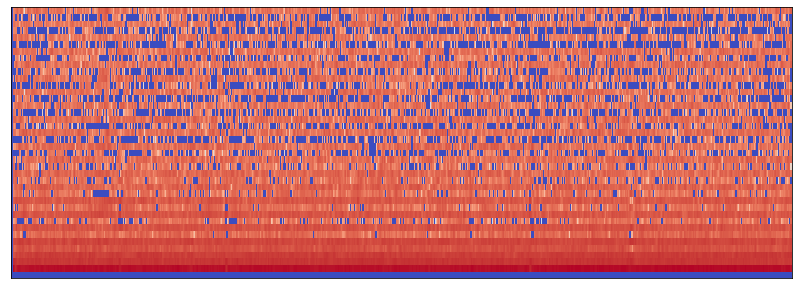

In [ ]:
# Plotting a audio recording
audios = get_audio_paths()
clip, sr = librosa.load(audios[3])
mfccs = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=40)
fig, ax = plt.subplots(figsize = (14, 5))
librosa.display.specshow(librosa.power_to_db(mfccs))

In [ ]:
def train_test_data():
  # Splitting the data into train and test
  X, y = get_features_labels()
  y = LabelBinarizer().fit_transform(y)
  return train_test_split(X.reshape(-1, 40, 862, 1), y, test_size = 0.2)

X_train, X_test, y_train, y_test = train_test_data()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((651, 40, 862, 1), (651, 6), (163, 40, 862, 1), (163, 6))

In [ ]:
def create_model():
  # Creating the model
  model = Sequential([
                      Conv2D(32, (3, 3), padding = "same", activation = "relu", input_shape = (40, 862, 1)), # First convolutional layer
                      MaxPool2D((2, 2)),
                      BatchNormalization(),
                      Conv2D(64, (3, 3), padding = "same", activation = "relu"), # Second convolutional layer
                      Conv2D(64, (3, 3), padding = "same", activation = "relu"), # Third convolutional layer
                      MaxPool2D((2, 2)),
                      BatchNormalization(),
                      Conv2D(128, (3, 3), padding = "same", activation = "relu"),# Fourth convolutional layer
                      MaxPool2D((2, 2)),
                      Flatten(),
                      Dense(64, activation = "relu"),# Hidden layer
                      Dropout(0.3),
                      Dense(6, activation = "softmax")# Output layer
  ])

  # Specifying Loss function, optimizer with learning rate and the evaluation metric
  model.compile(optimizer = Adam(lr = 3e-4),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 862, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 431, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 431, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 431, 64)       18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 431, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 215, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 215, 64)       2

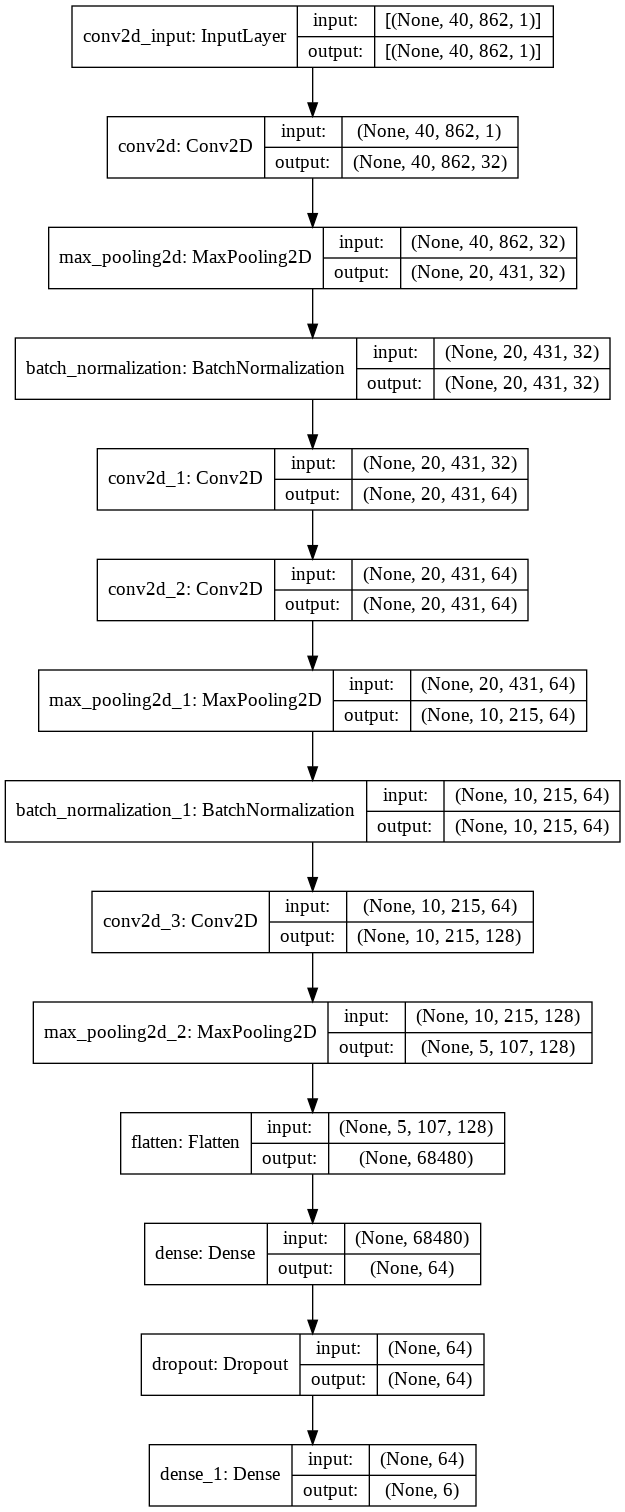

In [ ]:
# Plotting the CNN Architecture in a diagram
plot_model(model, show_shapes=True, show_layer_names = True)

In [ ]:
def train_model(model, epochs, batch_size = 32):
  # Reducing learning rate when the model takes a flat road during training
  reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=5,
                                min_lr=0.0001,
                                verbose = 1,
                                mode = "min")
  
  # Training the model on the training set
  history = model.fit(X_train, y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (X_test, y_test),
                    callbacks = [reduce_lr]
                    )
  return history

history = train_model(model, 100, 32)

Epoch 1/100
21/21 [==============================] - 10s 95ms/step - loss: 2.7786 - accuracy: 0.7010 - val_loss: 0.9377 - val_accuracy: 0.8528
Epoch 2/100
21/21 [==============================] - 1s 58ms/step - loss: 0.5260 - accuracy: 0.8236 - val_loss: 1.4654 - val_accuracy: 0.8528
Epoch 3/100
21/21 [==============================] - 1s 58ms/step - loss: 0.3900 - accuracy: 0.8454 - val_loss: 1.4893 - val_accuracy: 0.7607
Epoch 4/100
21/21 [==============================] - 1s 58ms/step - loss: 0.3494 - accuracy: 0.8524 - val_loss: 1.0822 - val_accuracy: 0.8528
Epoch 5/100
21/21 [==============================] - 1s 58ms/step - loss: 0.2631 - accuracy: 0.8847 - val_loss: 0.9302 - val_accuracy: 0.8589
Epoch 6/100
21/21 [==============================] - 1s 58ms/step - loss: 0.2888 - accuracy: 0.8713 - val_loss: 0.5573 - val_accuracy: 0.8957
Epoch 7/100
21/21 [==============================] - 1s 58ms/step - loss: 0.3110 - accuracy: 0.8661 - val_loss: 0.8961 - val_accuracy: 0.8160
Epoch

In [ ]:
# Checking the loss and accuracy of the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss : " + str(test_loss))
print("Test Accuracy : " + str(test_acc))

6/6 [==============================] - 0s 16ms/step - loss: 0.8910 - accuracy: 0.8957
Test Loss : 0.8910333514213562
Test Accuracy : 0.89570552110672


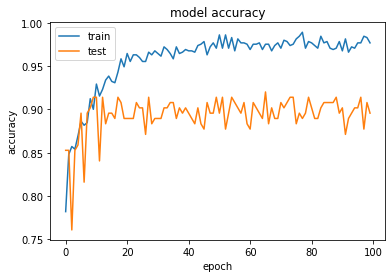

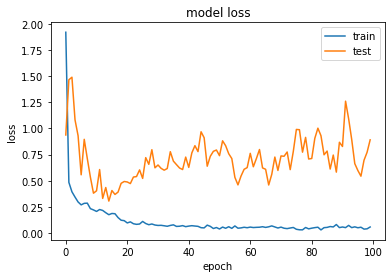

In [ ]:
# Plotting Loss and Accuracy graph for both training and testing data
def observe_loss_accuracy(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("model accuracy")
  plt.xlabel('epoch')
  plt.ylabel("accuracy")
  plt.legend(['train', 'test'])
  plt.show()

# Plotting the train and test loss of the model
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("model loss")
  plt.xlabel('epoch')
  plt.ylabel("loss")
  plt.legend(['train', 'test'])
  plt.show();

observe_loss_accuracy(history)

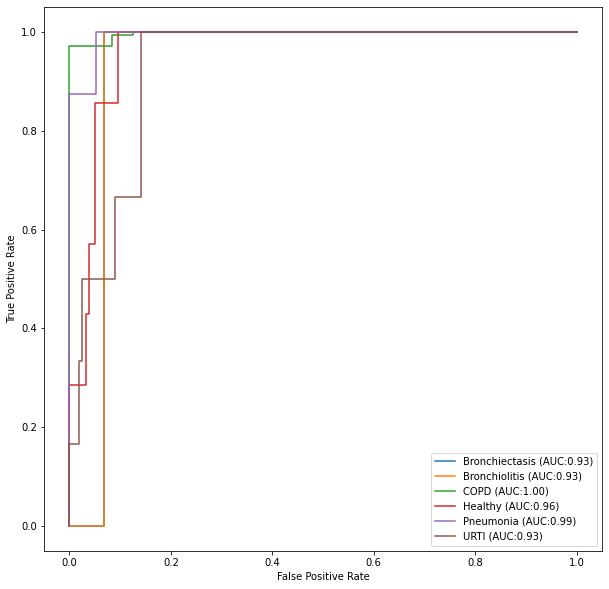

In [ ]:
# Making predictions for X_test
y_preds = model.predict(X_test)

# Plotting an ROC curve for each class

def plot_roc_curve(predictions, ground_truth):
  fig, ax = plt.subplots(figsize = (10, 10))
  for i, val in enumerate(list(disease)):
      fpr, tpr, thresholds = roc_curve(ground_truth[:,i].astype(int), predictions[:,i])
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (val, auc(fpr, tpr)))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')

plot_roc_curve(y_preds, y_test)

In [ ]:
# Saving the model
model.save("respiratory-model.h5", save_format = "h5")

In [ ]:
model.predict(X_test[0].reshape(1, 40, 862, 1))

array([[2.87863484e-04, 1.33522079e-07, 9.98872936e-01, 1.09450986e-04,
        7.25102844e-04, 4.41677184e-06]], dtype=float32)